<a href="https://colab.research.google.com/github/SaiEshwar-Pennada/Brain_Tumor_Detection/blob/main/Brain_tumor_detector_using_ResNet50V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
Root = "/content/drive/My Drive/archive/brain_tumor_dataset"
os.chdir(Root)

In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2

In [ ]:
data = '/content/drive/My Drive/archive/brain_tumor_dataset/'
No_brain_tumor = '/content/drive/My Drive/archive/brain_tumor_dataset/no/'
Yes_brain_tumor = '/content/drive/My Drive/archive/brain_tumor_dataset/yes/'

In [ ]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [ ]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/drive/My Drive/archive/brain_tumor_da...,No
1,/content/drive/My Drive/archive/brain_tumor_da...,No
2,/content/drive/My Drive/archive/brain_tumor_da...,No
3,/content/drive/My Drive/archive/brain_tumor_da...,No
4,/content/drive/My Drive/archive/brain_tumor_da...,No


In [ ]:
print(df['labels'].value_counts())

Yes    155
No      98
Name: labels, dtype: int64


KeyboardInterrupt: ignored

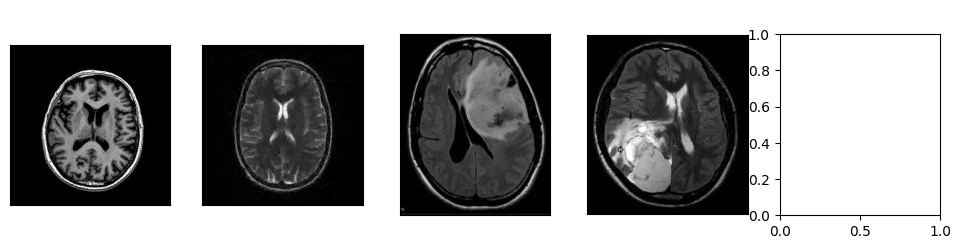

In [ ]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white")
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (216, 2)
test set shape: (13, 2)
validation set shape: (24, 2)


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32,
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid,
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels',
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 216 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [ ]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [ ]:
from keras.src.applications import ResNet50V2
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False
# Create new model on top
input_tensor = keras.Input(shape=(224, 224, 3))

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(input_tensor, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(input_tensoer, outputs)

model.summary()

NameError: ignored

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 100,
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 1.1162 - accuracy: 0.4213

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 63s 8s/step - loss: 1.1162 - accuracy: 0.4213 - val_loss: 0.9014 - val_accuracy: 0.5000
Epoch 2/100
7/7 [==============================] - 47s 7s/step - loss: 1.0485 - accuracy: 0.3935 - val_loss: 0.8109 - val_accuracy: 0.5417
Epoch 3/100
7/7 [==============================] - 45s 7s/step - loss: 0.8804 - accuracy: 0.4722 - val_loss: 0.7005 - val_accuracy: 0.5000
Epoch 4/100
7/7 [==============================] - 45s 6s/step - loss: 0.7581 - accuracy: 0.5278 - val_loss: 0.7913 - val_accuracy: 0.4583
Epoch 5/100
7/7 [==============================] - 45s 6s/step - loss: 0.7732 - accuracy: 0.4861 - val_loss: 0.7606 - val_accuracy: 0.5417
Epoch 6/100
7/7 [==============================] - 49s 7s/step - loss: 0.6729 - accuracy: 0.6111 - val_loss: 0.7238 - val_accuracy: 0.6667
Epoch 7/100
7/7 [==============================] - 43s 6s/step - loss: 0.6873 - accuracy: 0.5926 - val_loss: 0.7573 - val_accuracy: 0.4583
Epoch 8/100
7/7 [======================

In [ ]:
fin_json=model.to_json()
with open ('tumor.json','w') as json_file:
    json_file.write(fin_json)
model.save_weights('Tumor.h5')

In [ ]:
from tensorflow.keras.models import model_from_json
model=model_from_json(open('tumor.json','r').read())
model.load_weights('Tumor.h5')

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
from PIL import Image
model_path = "/content/drive/MyDrive/archive/brain_tumor_dataset/Tumor_classifier_model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/My Drive/archive/brain_tumor_dataset/yes/Y113.JPG")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
result = pred.argmax()
result

In [ ]:
train_gen.class_indices